# Ensemble Methods

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_decision_map(x, model, ax, **kwargs):
    x1min, x2min = x.min(axis=0)
    x1max, x2max = x.max(axis=0)
    X1map, X2map = np.mgrid[x1min:x1max:0.05, x2min:x2max:0.05]
    ypreds = model.predict(np.c_[X1map.reshape(-1, 1), X2map.reshape(-1, 1)])
    ypreds = ypreds.reshape(X1map.shape)
    ax.contourf(X1map, X2map, ypreds, **kwargs)
    ax.set_xlim(x1min, x1max)
    ax.set_ylim(x2min, x2max)

## Voting Classifiers

In [49]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(500, noise=0.3, random_state=42)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, random_state=42)

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [51]:
# Hard Voting Classifier: For a given training instance, take the
# mode of all predicted classes.

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_clf),
        ("rf", rnd_clf),
        ("svc", svm_clf)
    ],
    voting="hard"
)

voting_clf.fit(xtrain, ytrain)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [52]:
print("..Hard Voting Classifier Results..")
from sklearn.metrics import accuracy_score
for clf in [log_clf, rnd_clf, svm_clf, voting_clf]:
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    clf_name = clf.__class__.__name__
    print(f"{clf_name:>22}: {accuracy_score(ytest, ypred):0.3%}")

..Hard Voting Classifier Results..
    LogisticRegression: 86.400%
RandomForestClassifier: 87.200%
                   SVC: 88.800%
      VotingClassifier: 89.600%


**Note:** In this example, that the `VotingClassifier` surpassed all other classifiers is mereley probabilisitic. Modifying how the data is split, or the how the data is generated yield to a lower `VotingClassifier` accuracy

In [53]:
# Soft Voting Classifier: Predict the class with the highest probability,
# averaged over all individual classifiers

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[
        ("lr", log_clf),
        ("rf", rnd_clf),
        ("svc", svm_clf)
    ],
    voting="soft"
)

voting_clf.fit(xtrain, ytrain)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [54]:
print("..Soft Classifier Results..")
from sklearn.metrics import accuracy_score
for clf in [log_clf, rnd_clf, svm_clf, voting_clf]:
    clf.fit(xtrain, ytrain)
    ypred = clf.predict(xtest)
    clf_name = clf.__class__.__name__
    print(f"{clf_name:>22}: {accuracy_score(ytest, ypred):0.3%}")

..Soft Classifier Results..
    LogisticRegression: 86.400%
RandomForestClassifier: 87.200%
                   SVC: 88.800%
      VotingClassifier: 91.200%


## Bagging and Pasting

In [55]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), # The model to fit
    n_estimators=500, # The number of trees to work with
    max_samples=100, # Number of training instances for each tree
    bootstrap=True, # Set bagging to True; else pasting
    n_jobs=-1 # Number of CPUs to train the model
)

bag_clf.fit(xtrain, ytrain)
ypred = bag_clf.predict(xtest)

In [56]:
accuracy_score(ytest, ypred)

0.92000000000000004

### Decision Tree with Bagging v.s. a decision tree classifier

In [58]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

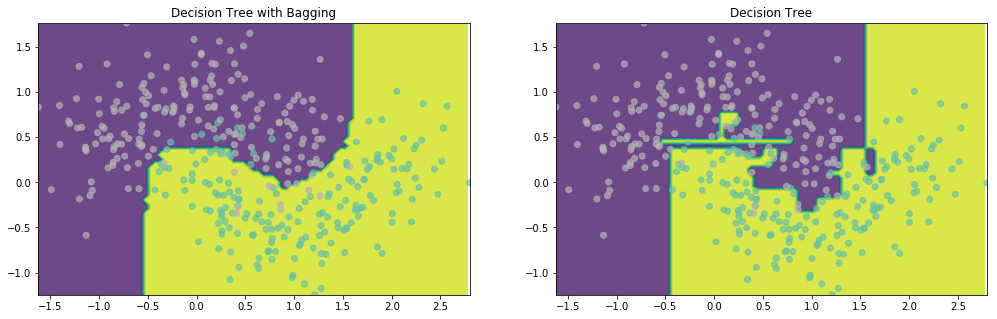

In [88]:
fig = plt.figure(figsize=(17,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot_decision_map(xtrain, bag_clf, ax1, alpha=0.8)
plot_decision_map(xtrain, tree_clf, ax2, alpha=0.8)
ax1.set_title("Decision Tree with Bagging")
ax2.set_title("Decision Tree")
for ax in (ax1, ax2):
    ax.scatter(*xtrain.T, c=ytrain, cmap=plt.cm.Set2_r, alpha=0.7)

### Out-of-Bag (OOB) Evaluation

When bootstraping, around 63% of the data gets evaluated, the remaining 37% result as unobserved variables. In scikit-learn we can make use of the 37% to evaluate as a cross-validation set in what is called an OOB evaluation.

In [124]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=314), # the model to perform bootstrap
    n_estimators=500,                         # number of trees to consider
    bootstrap=True,                           # resample with replacement 
    n_jobs=-1,                                # use all available CPUs
    oob_score=True,                           # Out of Bag evaluation score
    random_state=314
)

bag_clf.fit(xtrain, ytrain)
bag_clf.oob_score_

0.89866666666666661

In [125]:
from sklearn.metrics import accuracy_score
accuracy_score(bag_clf.predict(xtest), ytest)

0.90400000000000003

### Random Forests
**An ensemble of decision trees**

In [126]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
forest_clf.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Feature Importance (On decision trees and random forests)
> It is possible to get an estimate of a feature's imporance by computing the average depth at which it appears across all trees in the forest. 

In [143]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

iris = load_iris()
forest_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
forest_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], forest_clf.feature_importances_):
    print(f"{name:>17}: {score:>9.4%}")

sepal length (cm):   8.6083%
 sepal width (cm):   2.3123%
petal length (cm):  45.4072%
 petal width (cm):  43.6722%
